# Gradient descent types

Three types of gradient descent are considered:
- Batch gradient descent
- Stochastic gradient descent
- Mini batch gradient descent

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

### Data preparation
We use artificially generated data points based on a simple linear model parametrised by two parameters [k,q]. Uniformly generated random noise will be added.

Generated data will be represented by a list of tuples `(x, model(x)+noise)`

In [14]:
# constants of a generative linear model k*x + q
k_m = 3       # slope
q_m = -2      # initial value

# limit for additive noise
eps_m = 0.0

# generative model
gen_model = lambda x: k_m * x + q_m + random.uniform(-eps_m, eps_m)

In [15]:
# number of available data samples
npoints = 4

data = (random.uniform(-2.0, 2.0) for _ in range(npoints))
data = [(x, gen_model(x)) for x in data]
data

[(0.9583953193329231, 0.8751859579987693),
 (-0.4807180452379094, -3.442154135713728),
 (0.47173735280179496, -0.5847879415946151),
 (-0.0035747497703124687, -2.0107242493109374)]

### Model definition

To approximate available data, we define a linear model with two currently unknown parameters - **k** and **q**
$$m(x) = k x + q$$
Different values of these parameters provide different models approximating data - some value combinations are better or worse than the other value pairs.
To measure the quality of the produced model, we use MSE (mean square error) 
$$MSE = \frac{1}{2} (y_{data} - y_{model})^2$$
which can be approximated as a mean over all data points
$$MSE = \frac{1}{m} \sum_{i=1}^m \frac{1}{2} (y_{data}(i) - y_{model}(i))^2$$


In [16]:
# model generator
def get_model(k, q):
    return lambda x: k*x + q

In [17]:
def mse(model, data):
    L = []
    for x, y_data in data:
        mse = 0.5 * (y_data - model(x))**2
        L.append(mse)
    L = sum(L) / len(L)
    return L

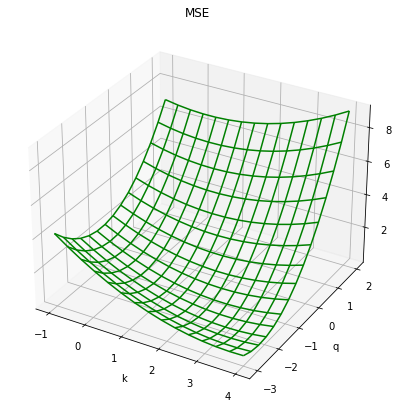

In [18]:
a = np.linspace(k_m-4.0, k_m+1.0, 15)   # samples for parameter k
b = np.linspace(q_m-1.0, q_m+4.0, 15)   # samples for parameter q
x, y = np.meshgrid(a, b)

# mse tabelation
def mse_tab(x, y):
    return np.array([[ mse( get_model(x[j,i], y[j,i]), data) 
                          for i in range(x.shape[1])]
                      for j in range(x.shape[0])])

plt.figure(figsize=(10,7))
wf = plt.axes(projection='3d')
wf.plot_wireframe(x, y, mse_tab(x,y), color ='green')
wf.set_title('MSE')
wf.set(xlabel="k", ylabel="q")
plt.show()

### Gradient computation
Since the aim is to find a model, which is the best possible approximation of available data, we face the task of minimizing MSE by tweaking values of model parameters $\theta = [k,q]$. It is possible to use iterative approach - model parameters can be modified a bit in each iteration. The modification is based on gradient of the minimized MSE
$$\theta_{t+1} = \theta_t - \alpha \nabla_{\theta_t} MSE$$
where $\alpha$ represents learning rate. Minus sign was used due to minimization - we want to move in a direction, which leads to lower values of MSE.

Considering the selected form of used model, gradient can be calculated
$$
\nabla_{\theta_t} MSE = \left[ \begin{array}{c} \nabla_{k_t} MSE \\ \nabla_{q_t} MSE \\ \end{array} \right] =
\left[ \begin{array}{c} (y_{data} - (k_t x + q_t))(-x) \\ (y_{data} - (k_t x + q_t))(-1) \\ \end{array} \right]
$$
which can be again approximated as a mean over a (sub)set of data points
$$
\left[ \begin{array}{c} \frac{1}{m} \sum_{i=1}^m (y_{data}(i) - (k_t x(i) + q_t))(-x(i)) \\ 
\frac{1}{m} \sum_{i=1}^m (y_{data}(i) - (k_t x(i) + q_t))(-1) \\ \end{array} \right]
$$


In [7]:
#gradient generator
def get_grad_k(k, q):
    return lambda x, y: (k * x + q - y) * x
def get_grad_q(k, q):
    return lambda x, y: (k * x + q - y)

In [8]:
def gradient(grad_k, grad_q, samples):
    agrk, agrq = [], []
    for sample in samples:
        gr_k = grad_k(*sample)
        gr_q = grad_q(*sample)
        agrk.append(gr_k)
        agrq.append(gr_q)
    agrk = sum(agrk) / len(agrk)
    agrq = sum(agrq) / len(agrq)
    return agrk, agrq

gradient(get_grad_k(k_m, q_m), get_grad_q(k_m, q_m), data)

(-0.006055452323231056, -0.011256239907706744)

### Model fitting

Iterative procedure starting with an initial guess for model parameters $\theta = [k, q]$. The procedure is controlled by 
- learnig rate
- number of performed iterations

In [9]:
# Initial estimation of model parameters
k_init = -1
q_init = 1

# learning rate
α = 0.2

# number of iterations
iters = 15

In [10]:
# Visualisation of fitting iterations

# preparation of parameter space
a = np.linspace(min(k_init, k_m)-0.5, max(k_init, k_m)+0.5, 20)   # samples for parameter k
b = np.linspace(min(q_init, q_m)-0.5, max(q_init, q_m)+0.5, 20)   # samples for parameter q
x, y = np.meshgrid(a, b)
# preparation of contours in parameter space
z = np.array([[ mse(get_model(x[j,i],y[j,i]),data) for i in range(x.shape[1])]
              for j in range(x.shape[0])])

def graphs(Ks, Qs, MSEs):
    fig, (sub1, sub2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=False)

    sub1.set_title("Trajectory in parameter space (blue - init, red - goal)")
    ourplot1=sub1.contour(x,y,z,levels=30)
    sub1.plot(Ks,Qs,'go-')
    sub1.plot([k_init],[q_init],'bo')
    sub1.plot([3],[-2],'ro')
    sub1.clabel(ourplot1, fontsize=10)
    sub1.set(xlabel="k", ylabel="q")

    sub2.set_title("MSE")
    sub2.plot(range(len(MSEs)), MSEs, 'bo-')
    sub2.set(xlabel="iteration", ylabel="MSE")

    plt.show()

### Batch gradient descent

Batch gradient descent is also known as Vanilla gradient descent or Gradient descent (GD).
Gradient calculation is based on ALL available data samples for every model parameter update.
$$m = \mid data \mid$$
Model parameters are not changed until all samples have been considered.

- provides stable (reproducible) convegence
- stable convergence can cause model to converge prematurely (to suboptimal values)
- most computationaly demanding per one update of parameters
- typically slow with biggest computational requirements
- problems with large data sets

θ = [ -1, 1 ]   MSE = 22.103
iter :  1   used samples : all   θ = [ 0.241, -0.293 ]   MSE = 8.9669
iter :  2   used samples : all   θ = [  1.03, -1.11 ]   MSE = 3.6506
iter :  3   used samples : all   θ = [  1.54, -1.63 ]   MSE = 1.4985
iter :  4   used samples : all   θ = [  1.87, -1.95 ]   MSE = 0.627
iter :  5   used samples : all   θ = [  2.08, -2.16 ]   MSE = 0.27368
iter :  6   used samples : all   θ = [  2.22, -2.28 ]   MSE = 0.13008
iter :  7   used samples : all   θ = [  2.31, -2.36 ]   MSE = 0.071366
iter :  8   used samples : all   θ = [  2.38,  -2.4 ]   MSE = 0.047021
iter :  9   used samples : all   θ = [  2.42, -2.43 ]   MSE = 0.036604
iter : 10   used samples : all   θ = [  2.45, -2.44 ]   MSE = 0.03184
iter : 11   used samples : all   θ = [  2.47, -2.45 ]   MSE = 0.029381
iter : 12   used samples : all   θ = [  2.49, -2.45 ]   MSE = 0.027871
iter : 13   used samples : all   θ = [  2.51, -2.44 ]   MSE = 0.026762
iter : 14   used samples : all   θ = [  2.52, -2.44 ]   MSE

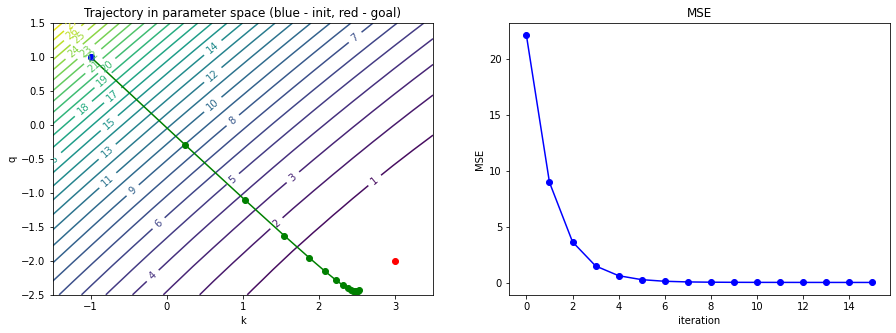

In [11]:
k, q = k_init, q_init

MSEs = [mse(get_model(k,q),data)]
print(f"θ = [ {k}, {q} ]   MSE = {MSEs[-1]:.5}")

Ks, Qs = [k], [q]
for i in range(iters):
    grk, grq = gradient(get_grad_k(k, q), get_grad_q(k, q), data)

    k = k - α * grk
    q = q - α * grq
    Ks.append(k)
    Qs.append(q)
    MSEs.append(mse(get_model(k,q), data))

    print(f"iter : {i+1:2}   used samples : all"
        f"   θ = [ {k:5.3}, {q:5.3} ]   MSE = {MSEs[-1]:.5}")
    
graphs(Ks, Qs, MSEs)

### Stochastic gradient descent

Stochastic gradient descent (SGD) uses gradient calculation based on one data sample for every model parameter update.
$$m = 1$$
The data sample can be selected in a deterministic or stochastic way.

- the least computationaly expensive per one parameter update
- typically faster than GD and requiring less computational power
- noisy update process providing better chance to avoid local minima
- noisy update produces more variance during parameter fitting

θ = [ -1, 1 ]   MSE = 22.103
iter :  1   used samples : [2]   θ = [ 0.268, -0.349 ]   MSE = 8.6297
iter :  2   used samples : [0]   θ = [ 0.387, -0.804 ]   MSE = 6.5
iter :  3   used samples : [0]   θ = [  0.48, -1.16 ]   MSE = 5.045
iter :  4   used samples : [2]   θ = [  1.08,  -1.8 ]   MSE = 2.0177
iter :  5   used samples : [0]   θ = [  1.11, -1.92 ]   MSE = 1.7413
iter :  6   used samples : [2]   θ = [  1.46, -2.29 ]   MSE = 0.73469
iter :  7   used samples : [0]   θ = [  1.46,  -2.3 ]   MSE = 0.72838
iter :  8   used samples : [1]   θ = [   1.7, -2.54 ]   MSE = 0.31096
iter :  9   used samples : [3]   θ = [   2.0, -2.78 ]   MSE = 0.091013
iter : 10   used samples : [1]   θ = [  2.05, -2.82 ]   MSE = 0.081516
iter : 11   used samples : [3]   θ = [  2.16, -2.91 ]   MSE = 0.083664
iter : 12   used samples : [1]   θ = [  2.15,  -2.9 ]   MSE = 0.081069
iter : 13   used samples : [2]   θ = [  2.13, -2.87 ]   MSE = 0.07793
iter : 14   used samples : [1]   θ = [  2.13, -2.88 ]   MSE = 0.

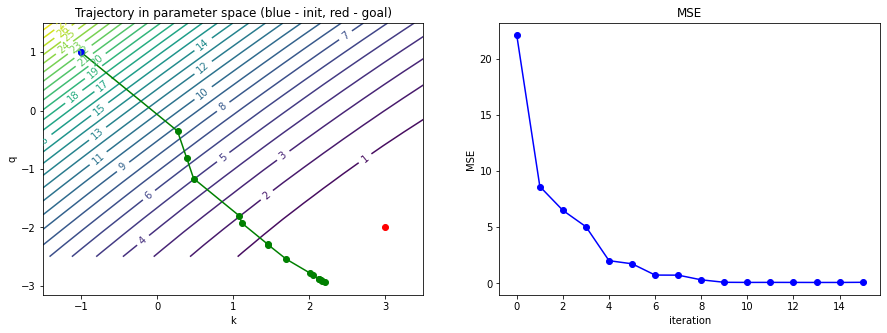

In [12]:
k, q = k_init, q_init

MSEs = [mse(get_model(k,q),data)]
print(f"θ = [ {k}, {q} ]   MSE = {MSEs[-1]:.5}")

Ks, Qs = [k], [q]
for i in range(iters):
    examples = random.sample(range(len(data)), 1)
    sample = [data[i] for i in examples]
    grk, grq = gradient(get_grad_k(k, q), get_grad_q(k, q), sample)

    k = k - α * grk
    q = q - α * grq
    Ks.append(k)
    Qs.append(q)
    MSEs.append(mse(get_model(k,q), data))
    
    print(f"iter : {i+1:2}   used samples : {examples}"
         f"   θ = [ {k:5.3}, {q:5.3} ]   MSE = {MSEs[-1]:.5}")

graphs(Ks, Qs, MSEs)

## Mini batch gradient descent

Gradient calculation is based on a subset of data samples for every model parameter update. Divides available training data into manageable groups.
$$1 < m < \mid data \mid$$
The subset of data samples can be selected in a deterministic or stochastic way.

Combines GD and SGS to obtain best of the both worlds. Usually preferred technique.
- more robust covergence than stochastic gradient descent
- requires one additional hyperparameter (batch size)

θ = [ -1, 1 ]   MSE = 22.103
iter :  1   used samples : [3, 2, 1]   θ = [ 0.586, -0.46 ]   MSE = 7.0307
iter :  2   used samples : [3, 1, 2]   θ = [  1.49, -1.29 ]   MSE = 2.2204
iter :  3   used samples : [1, 2, 3]   θ = [   2.0, -1.76 ]   MSE = 0.69592
iter :  4   used samples : [2, 3, 0]   θ = [  2.22, -1.97 ]   MSE = 0.30439
iter :  5   used samples : [0, 2, 1]   θ = [  2.32, -2.08 ]   MSE = 0.1687
iter :  6   used samples : [1, 2, 3]   θ = [  2.46, -2.22 ]   MSE = 0.058702
iter :  7   used samples : [2, 0, 1]   θ = [   2.5, -2.25 ]   MSE = 0.042613
iter :  8   used samples : [0, 1, 2]   θ = [  2.53, -2.26 ]   MSE = 0.033631
iter :  9   used samples : [2, 3, 0]   θ = [  2.57, -2.28 ]   MSE = 0.024667
iter : 10   used samples : [0, 2, 1]   θ = [  2.58, -2.29 ]   MSE = 0.022682
iter : 11   used samples : [1, 2, 0]   θ = [  2.59, -2.29 ]   MSE = 0.021246
iter : 12   used samples : [2, 3, 1]   θ = [  2.63, -2.32 ]   MSE = 0.016872
iter : 13   used samples : [2, 0, 1]   θ = [  2.63,  -2

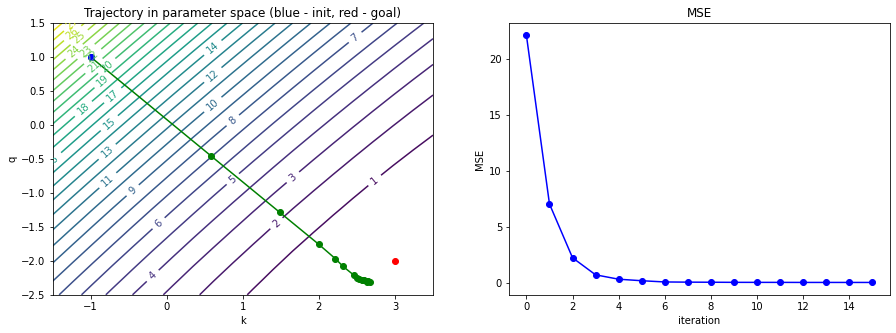

In [13]:
bs = 3   # batch size
assert bs < npoints, "MUst be less than all data"

k, q = k_init, q_init

MSEs = [mse(get_model(k,q),data)]
print(f"θ = [ {k}, {q} ]   MSE = {MSEs[-1]:.5}")

Ks, Qs = [k], [q]
for i in range(iters):
    examples = random.sample(range(len(data)), bs)
    batch = [data[i] for i in examples]
    grk, grq = gradient(get_grad_k(k, q), get_grad_q(k, q), batch)

    k = k - α * grk
    q = q - α * grq
    Ks.append(k)
    Qs.append(q)
    MSEs.append(mse(get_model(k,q), data))
    
    print(f"iter : {i+1:2}   used samples : {examples}"
         f"   θ = [ {k:5.3}, {q:5.3} ]   MSE = {MSEs[-1]:.5}")

graphs(Ks, Qs, MSEs)